In [1]:
import os
import numpy as np
import argparse


import pandas as pd
from sklearn.decomposition import PCA
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import umap.umap_ as umap
import time

import torch
from spiral.main import SPIRAL_integration
from spiral.layers import *
from spiral.utils import *
from spiral.CoordAlignment import CoordAlignment
from sklearn.metrics.pairwise import euclidean_distances
R_dirs="/home/tguo/tguo2/miniconda3/envs/stnet/lib/R"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

step1: SPIRAL integration

In [2]:
dirs="/data02/tguo/space_batch_effect/mouse_OB/"
samples=["BGI","SlideV2"]
SEP=','
net_cate='_KNN_'
knn=8

N_WALKS=knn
WALK_LEN=1
N_WALK_LEN=knn
NUM_NEG=knn


feat_file=[]
edge_file=[]
meta_file=[]
coord_file=[]
flags=''
for i in range(len(samples)):
    feat_file.append(dirs+"gtt_input/BGI_SlideV2_10X/"+str(samples[i])+"_mat.csv")
    edge_file.append(dirs+"gtt_input/BGI_SlideV2_10X/"+str(samples[i])+"_edge"+net_cate+str(knn)+".csv")
    meta_file.append(dirs+"gtt_input/BGI_SlideV2_10X/"+str(samples[i])+"_meta.csv")
    coord_file.append(dirs+"gtt_input/BGI_SlideV2_10X/"+str(samples[i])+"_coord.csv")
    flags=flags+'_'+samples[i]
N=pd.read_csv(feat_file[0],header=0,index_col=0).shape[1]
if (len(samples)==2):
    M=1
else:
    M=len(samples)

In [4]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=0, help='The seed of initialization.')
parser.add_argument('--AEdims', type=list, default=[N,[512],32], help='Dim of encoder.')
parser.add_argument('--AEdimsR', type=list, default=[32,[512],N], help='Dim of decoder.')
parser.add_argument('--GSdims', type=list, default=[512,32], help='Dim of GraphSAGE.')
parser.add_argument('--zdim', type=int, default=32, help='Dim of embedding.')
parser.add_argument('--znoise_dim', type=int, default=4, help='Dim of noise embedding.')
parser.add_argument('--CLdims', type=list, default=[4,[],M], help='Dim of classifier.')
parser.add_argument('--DIdims', type=list, default=[28,[32,16],M], help='Dim of discriminator.')
parser.add_argument('--beta', type=float, default=1.0, help='weight of GraphSAGE.')
parser.add_argument('--agg_class', type=str, default=MeanAggregator, help='Function of aggregator.')
parser.add_argument('--num_samples', type=int, default=20, help='number of neighbors to sample.')

parser.add_argument('--N_WALKS', type=int, default=N_WALKS, help='number of walks of random work for postive pairs.')
parser.add_argument('--WALK_LEN', type=int, default=WALK_LEN, help='walk length of random work for postive pairs.')
parser.add_argument('--N_WALK_LEN', type=int, default=N_WALK_LEN, help='number of walks of random work for negative pairs.')
parser.add_argument('--NUM_NEG', type=int, default=NUM_NEG, help='number of negative pairs.')

parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=512, help='Size of batches to train.')
parser.add_argument('--lr', type=float, default=1e-3, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay.')
parser.add_argument('--alpha1', type=float, default=N, help='Weight of decoder loss.')
parser.add_argument('--alpha2', type=float, default=1, help='Weight of GraphSAGE loss.')
parser.add_argument('--alpha3', type=float, default=1, help='Weight of classifier loss.')
parser.add_argument('--alpha4', type=float, default=1, help='Weight of discriminator loss.')
parser.add_argument('--lamda', type=float, default=1, help='Weight of GRL.')
parser.add_argument('--Q', type=float, default=10, help='Weight negative loss for sage losss.')

params,unknown=parser.parse_known_args()

In [5]:
SPII=SPIRAL_integration(params,feat_file,edge_file,meta_file)

In [ ]:
SPII.train()
if not os.path.exists(dirs+"model/"):
    os.makedirs(dirs+"model/")
torch.save(SPII.model.state_dict(),dirs+"model/SPIRAL"+flags+"_model_"+str(SPII.params.batch_size)+".pt")

--------------------------------
Training.
processed: 3:   3%|▎         | 3/100 [47:13<24:14:06, 899.44s/it, CLAS_loss=0.208, DISC_loss=0.307, GS_loss=9.77, total_loss=448]     

In [ ]:
SPII.model.eval()
all_idx=np.arange(SPII.feat.shape[0])
all_layer,all_mapping=layer_map(all_idx.tolist(),SPII.adj,len(SPII.params.GSdims))
all_rows=SPII.adj.tolil().rows[all_layer[0]]
all_feature=torch.Tensor(SPII.feat.iloc[all_layer[0],:].values).float().cuda()
all_embed,ae_out,clas_out,disc_out=SPII.model(all_feature,all_layer,all_mapping,all_rows,SPII.params.lamda,SPII.de_act,SPII.cl_act)
[ae_embed,gs_embed,embed]=all_embed
[x_bar,x]=ae_out
embed=embed.cpu().detach()
embed=embed[:,SPII.params.znoise_dim:]
names=['GTT_'+str(i) for i in range(embed.shape[1])]
embed1=pd.DataFrame(np.array(embed),index=SPII.feat.index,columns=names)
if not os.path.exists(dirs+"gtt_output/"):
    os.makedirs(dirs+"gtt_output/")

embed_file=dirs+"gtt_output/SPIRAL"+flags+"_embed_"+str(SPII.params.batch_size)+".csv"
embed1.to_csv(embed_file)

/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


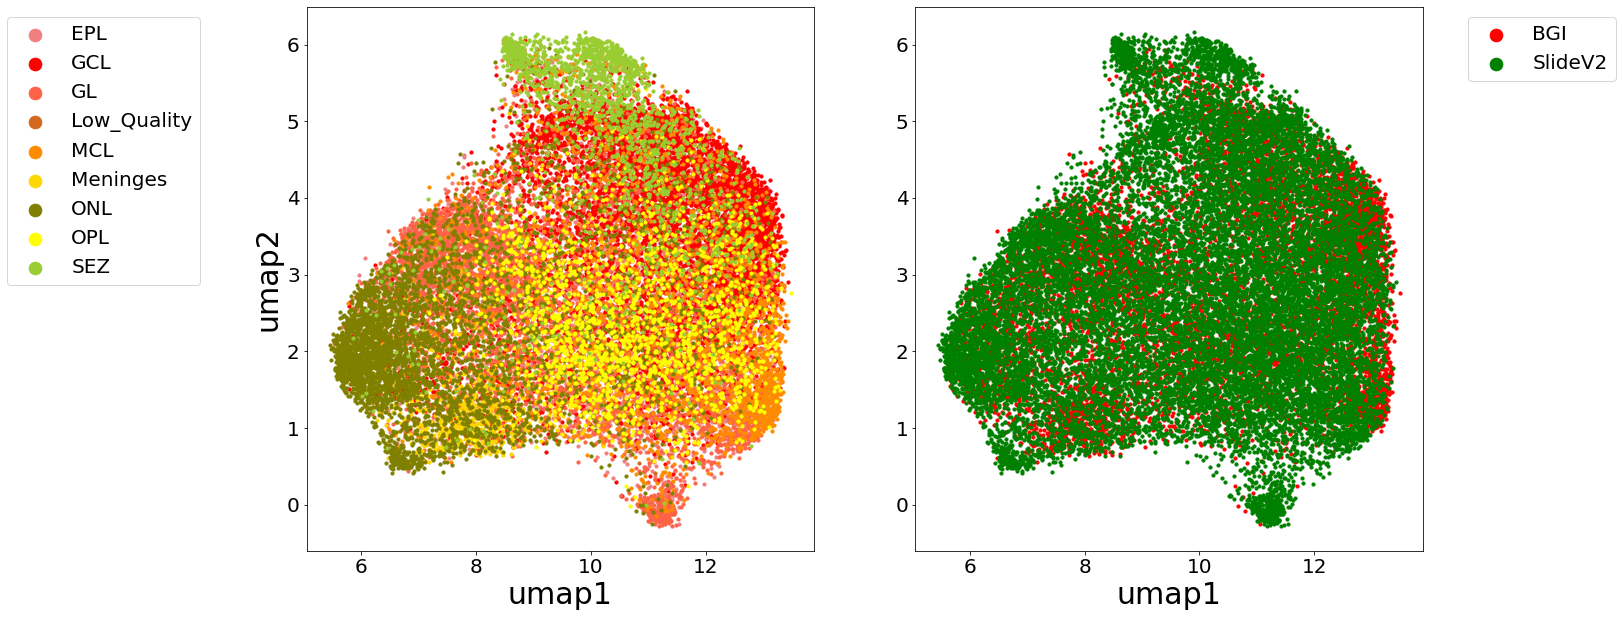

In [9]:
celltype=SPII.meta[:,0]
batch=SPII.meta[:,1]
ul=np.unique(celltype)
ub=np.unique(batch)
import umap.umap_ as umap
import matplotlib.pyplot as plt
umap_mat=umap.UMAP().fit_transform(embed)
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=10
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

step2: clustering by Seurat pipeline

In [ ]:
import anndata
import scanpy as sc
adata=anndata.AnnData(SPII.feat)
adata.obsm['spiral']=embed1.iloc[:,SPII.params.znoise_dim:].values
ann.obs['batch']=SPII.meta.loc[:,'batch']

coord=pd.read_csv(coord_file[0],header=0,index_col=0)
for i in np.arange(1,len(samples)):
    coord=pd.concat((coord,pd.read_csv(coord_file[i],header=0,index_col=0)))
    
ann.obsm['spatial']=coord.loc[ann.obs_names,:]
cluster=pd.read_csv(cluster_file,header=0,index_col=0)
adata.obs['SPIRAL']=cluster.loc[adata.obs_names,:]

step3: smooth clusters

In [25]:
from smooting_clustering import refine

adata.obs['SPIRAL_refine']=adata.obs['SPIRAL']
ub=np.unique(adata.obs['batch'])
for i in range(len(ub)):
    idx=np.where(adata.obs['batch']==ub[i])[0]
    ann1=adata[idx,:]
    sample_id=ann1.obs_names
    pred=ann1.obs[metric]
    dis=euclidean_distances(ann1.obsm['spatial'],ann1.obsm['spatial'])
    refined_pred=refine(sample_id, pred, dis, num_nbs=knn)
    adata.obs['SPIRAL_refine'][idx]=refined_pred

pd.DataFrame(adata.obs['SPIRAL_refine']).to_csv(cluster_file)

In [ ]:
size1=3
size2=1
metric='SPIRAL_refine'
adata1=adata[adata.obs['batch']==ub[0],:]
sc.pl.spatial(adata1,color=metric, spot_size=size1,legend_loc='on data')
adata1=adata[adata.obs['batch']==ub[1],:]
sc.pl.spatial(adata1,color=metric, spot_size=size2,legend_loc='on data')


step4: spiral alignment   (embed_file and cluster_file)

In [44]:
###########STAGATE annotation##########
# meta1=pd.read_csv(dirs+"methods/STAGATE_BGI_annotations.csv",header=0,index_col=0)
# meta1.loc[:,'batch']='BGI'
# meta1.to_csv(dirs+"methods/STAGATE_BGI_annotations.csv")

# meta2=pd.read_csv(dirs+"methods/STAGATE_SlideV2-v2_annotations.csv",header=0,index_col=0)
# meta2.loc[:,'batch']='SlideV2'
# meta2.columns=['celltype','batch']
# meta3=pd.read_csv(dirs+"gtt_input/BGI_SlideV2_10X/SlideV2_meta.csv",header=0,index_col=0)
# cells=np.intersect1d(meta3.index,meta2.index)
# meta2.loc[cells,:].to_csv(dirs+"methods/STAGATE_SlideV2_annotations.csv")

# coord2=pd.read_csv(coord_file[1],header=0,index_col=0)
# coord2.loc[cells,:].to_csv(dirs+"gtt_output/alignment_coord_SlideV2.csv")
# coord1=pd.read_csv(coord_file[0],header=0,index_col=0)
# coord1.to_csv(dirs+"gtt_output/alignment_coord_BGI.csv")

# embed_file=dirs+"gtt_output/AGC_embed"+flags+"_xent_512.csv"
# embed=pd.read_csv(embed_file,header=0,index_col=0)
# embed.loc[np.concatenate((np.array(coord1.index),cells)),:].to_csv(dirs+"gtt_output/alignment"+flags+"_embed.csv")

# clust=pd.read_csv(dirs+"metrics/spiral"+flags+"_seuratmethod_clust_modify_refine_512.csv",header=0,index_col=0)
# clust.loc[np.concatenate((np.array(coord1.index),cells))].to_csv(dirs+"metrics/alignment"+flags+"_cluster.csv")

In [3]:
embed_file=dirs+"gtt_output/alignment"+flags+"_embed.csv"
meta_file=[dirs+"methods/STAGATE_BGI_annotations.csv",dirs+"methods/STAGATE_SlideV2_annotations.csv"]
coord_file=[dirs+"gtt_output/alignment_coord_BGI.csv",dirs+"methods/STAGATE_SlideV2_annotations.csv"]
cluster_file=dirs+"metrics/alignment"+flags+"_cluster.csv"

In [4]:
clust_cate='seuratmethod'
input_file=[meta_file,coord_file,embed_file,cluster_file]
output_dirs=dirs+"gtt_output/SPIRAL_alignment/"
if not os.path.exists(output_dirs):
    os.makedirs(output_dirs)
# ub=np.unique(adata.obs['batch'])
ub=['BGI','SlideV2']

In [ ]:
alpha=0.5
types="weighted_mean"
clust_cate="seuratmethod"
R_dirs="/home/tguo/tguo2/miniconda3/envs/stnet/lib/R"
CA=CoordAlignment(input_file=input_file,output_dirs=output_dirs,ub=ub,flags=flags,clust_cate=clust_cate,R_dirs=R_dirs,alpha=alpha,types=types)
New_Coord=CA.New_Coord
New_Coord.to_csv(output_dirs+"new_coord"+flags+"_modify.csv")
# adata.obsm['aligned_spatial']=New_Coord.loc[adata.obs_names,:].values

/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/ot/lp/__init__.py:329: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


In [ ]:
New_Coord1=CA.New_Coord.values
celltype=New_Coord1[:,3]
ul=np.unique(celltype)
import matplotlib.pyplot as plt
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,1,figsize=(10,10))
size=50
for i in range(len(ul)):
    axs.scatter(New_Coord1[np.where(celltype==ul[i])[0],0],New_Coord1[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs.set_xlabel("x",fontsize=30)
axs.set_ylabel("y",fontsize=30)
axs.legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs.tick_params(axis='both', which='major', labelsize=20)

step5:predict 10X Visium

In [ ]:
from sklearn.preprocessing import minmax_scale
knn_pred=6
feat_test=pd.read_csv(feat_file_10X,header=0,index_col=0,sep=SEP)
edge_test=np.loadtxt(edge_file_10X,dtype=str)
meta_test=pd.read_csv(meta_file_10X,header=0,index_col=0)
if len(edge_test.shape)<2:
    edge_test=np.array([[i.split(":")[0],i.split(":")[1]] for i in edge])
node_mapping_test=[{j:i for(i,j) in enumerate(feat_test.index)}]
node_mapping_test=node_mapping_test[0]
edge_test=np.array([[node_mapping_test[i[0]],node_mapping_test[i[1]]] for i in edge_test])    
adj_test=process_adj(edge_test,feat_test.shape[0])

x=minmax_scale(feat_test.values,axis=1)
feat_test=pd.DataFrame(x,index=feat_test.index,columns=feat_test.columns)
ub_test=np.unique(meta_test.loc[:,'batch'])
Y_test=np.array([0 if i==ub_test[0] else 1 for i in meta_test.loc[:,'batch']])

In [ ]:
# model.load_state_dict(torch.load(model_file))
SPII.model.eval()
all_idx_test=np.arange(feat_test.shape[0])
all_layer_test,all_mapping_test=layer_map(all_idx_test.tolist(),adj_test,len(GSdims))
all_rows_test=adj_test.tolil().rows[all_layer_test[0]]
all_feature_test=torch.Tensor(feat_test.iloc[all_layer_test[0],:].values).float().cuda()
all_embed_test,ae_out_test,clas_out_test,disc_out_test=SPII.model(all_feature_test,all_layer_test,all_mapping_test,all_rows_test,SPII.params.lamda,SPII.de_act,SPII.cl_act)
[ae_embed_test,gs_embed_test,embed_test]=all_embed_test
[x_bar_test,x_test]=ae_out_test
embed_test=embed_test.cpu().detach()
######BGI和SlideV2 embed######
embed_1=np.vstack((embed_test,adata.obsm['spiral']))
cells=np.hstack((feat_test.index,adata.obs_names))
embed_combine=pd.DataFrame(embed_1,index=cells,columns=['SPIRAL-'+str(i) for i in range(embed_1.shape[1])])
embed_combine.to_csv(dirs+"gtt_output/AGC_embed"+flags+'_'+pred_sample+'_xent_'+str(BS)+"_modify.csv")



In [ ]:
feat_combine=pd.concat((SPII.feat,feat_test))
adata_combine=anndata.AnnData(feat_combine)
adata_combine['spiral']=embed_combine.loc[adata_combine.obs_names,:].values
meta_combine=pd.concat((SPII.meta,meta_test))
adata_combine.obs=meta_combine
coord_combine=pd.concat((coord,coord_test))
adata_combine['spatial']=coord_combine.loc[adata_combine.obs_names,:].values



step6: KNN prediction

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import euclidean_distances

idx1=np.where(adata_combine.obs['batch']!='10X')[0]
idx2=np.where(adata_combine.obs['batch']=='10X')[0]
embed_train=adata_combine.obsm['spiral'][idx1,:]
embed_test=adata_combine.obsm['spiral'][idx2,:]
clusters=pd.DataFrame(adata.obs['SPIRAL_refine'])

KNC=KNeighborsClassifier(n_neighbors=knn_pred)
KNC.fit(embed_train.values,clusters.values[:,0])
cluster_pred=KNC.predict(embed_test.values)
cluster_pred=pd.DataFrame(cluster_pred,index=embed_test.index,columns=['pred_clusters'])

dis=euclidean_distances(adata_combine.obsm['spatial'][idx2,:],adata_combine.obsm['spatial'][idx2,:])
refined_pred=refine(np.array(cluster_pred.index), cluster_pred.values[:,0], dis, knn_pred)
refined_pred=pd.DataFrame(refined_pred,index=embed_test.index,columns=['SPIRAL'])


clust_combine=pd.concat((pd.DataFrame(adata.obs['SPIRAL']),refined_pred))
adata_combine.obs['SPIRAL']=clust_combine.loc[adata_combine.obs_names,:]